# Optimizando funciones para redes con distintos métodos
**Edgar Baquero**

---

Para los ejercicios vamos a usar los datos generados por el modelo 

$$  f(x; \theta) = f(x; A, \omega, \phi) =  A\sin(\omega x + \phi)$$

y la función que mide el ajuste del modelo 

$$ L(\theta;  \mathbf{X},  \mathbf{y}) = \frac{1}{n} \sum_{i=1}^n ( f(x_i; \theta)  - y_i )^2 $$

donde  $\mathbf{X} = (x_1, x_2, ..., x_n)$ y $\mathbf{y} = (y_1, y_2, ..., y_n)$
y los puntos $(x_i, y_i)$ están generados por el siguiete código.

Parámetros generadores:  13 1.2 0.6


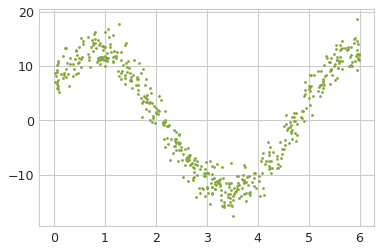

In [147]:
import numpy as np
import matplotlib.pyplot as plt
import random
from random import randrange
import time
from matplotlib.pyplot import figure

# Modelo
def fnc_f(x, theta):
    A,w,phi = theta
    return A*np.sin(w*x + phi)

A   = 13
w   = 1.2
phi = 0.6
print('Parámetros generadores: ', A, w, phi)

# Generación de los datos del problema, almacenados en los arreglos X,y
X     = np.random.rand(2**9)*6
theta = (A, w, phi)
y     = fnc_f(X, theta) + 2*np.random.randn(len(X))

# Gráfica de los datos
plt.plot(X, y, 'g.')

Usamos como punto inical  $\theta_0 = (18, 0.6, 0)$

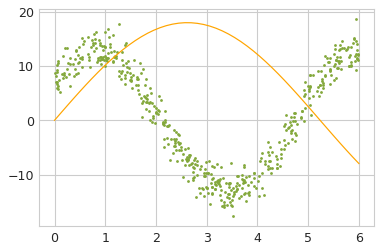

In [148]:
theta0 = [18, 0.6, 0]

vx     = np.linspace(0, 6, 50)
plt.plot(X, y, 'g.')
plt.plot(vx, fnc_f(vx, theta0), 'orange')

----

## Ejercicio 1 

Programar y probar el método de descenso de gradiente estocástico (SGD) con momentum de Nesterov para minimizar una función $L(\theta; \mathbf{X},  \mathbf{y})$ que mide el ajuste que tiene un modelo $f(x;\theta)$ a un conjunto de datos $\{(x_1, y_1), (x_2, y_2), ..., (x_n, y_n)\}$, de modo que

$$ f(x_i;\theta) = y_i + e_i \quad i=1,2,...,n, $$

donde $e_i$ es el error del modelo, $\mathbf{X} = (x_1, x_2, ..., x_n)$ y $\mathbf{y} = (y_1, y_2, ..., y_n)$.

La función que implementa el algoritmo debe recibir como parámetros:

- Un punto inicial $\theta_0$
- El gradiente de la función $L(\theta; \mathbf{X},  \mathbf{y})$ 
- Los arreglos $X$ y $\mathbf{y}$
- El tamaño $m$ del batch
- El número de épocas 
- Dos tolerancias $\tau_1, \tau_2$ 
- Un vector inicial de velocidad $v$
- El valor del learning rate $\epsilon>0$
- El factor $\alpha>0$

Esta función en cada época debe generar los bloques de datos (batches), usando una función como la que se muestra en la página 30 de las diapositivas, y luego usado cada batch hay que aplicar los pasos descritos en el algoritmo de la página 37.

Hay que usar como criterio de paro:
- El número de épocas o 
- La norma del gradiente de  $L(\theta; \mathbf{X},  \mathbf{y})$  sea menor que $\tau_1$.
- La norma de $v$ menor que $\tau_2$, que eso significa que no hay un incremento significativo en la variable $\theta$.

Hay que almacenar la secuencia de puntos $\theta$ que se van 
generando en cada iteración. La función debe devolver esta secuencia 
y el número de iteraciones realizadas.

1. Implementar el algoritmo el método de descenso de gradiente estocástico (SGD) con momentum de Nesterov como se describió.
2. Probar el algoritmo para el conjunto de puntos  y el modelo dados usando el
   punto inicial $\theta=(A, \omega, \phi) = (18, 0.6, 0)$, el valor
   $\alpha=0.001$, una tolerancia $\tau_1=0.01$, $\tau_2=0.0001$, $v = (0,0,0)$, $5000$ épocas (puede ajustar este valor si es necesario) y los
   tamaños de batch  $m = 16$ y $m=128$.
   Para cada $m$, probar el algoritmo usando learning rate $\epsilon=0.01$ y $\epsilon= 0.0001$
3. Reporte 

- el valor inicial $L(\theta_0; \mathbf{X},  \mathbf{y})$
- el valor de $\theta$ final obtenido, 
- el valor $L(\theta; \mathbf{X},  \mathbf{y})$ en  $\theta$ final,
- la norma del gradiente de $L(\theta; \mathbf{X},  \mathbf{y})$ evaluado en el valor final de $\theta$,
- el número de iteraciones realizadas, 
- el tiempo de cómputo,
- la gráfica del modelo $f(x;\theta)$ usando el valor de $\theta$ final comparada con los datos para apreciar el ajuste,
- una gráfica con los valores de $L(\theta_k; \mathbf{X},  \mathbf{y})$
  donde $\theta_k$ son los puntos generados por el algoritmo, 
- una gráfica del gradiente de $L$ evaluada en los puntos $\theta_k$, y
- una gráfica 3D de los puntos $\theta_k$ generados por el algoritmo.

4. Escriba un comentario sobre el efecto de los parámetros en los resultados del optimizador.

### Solución:

**Primero, calculamos el gradiente para la función dada**

In [155]:
def loss(X, y, func, theta):
    n = len(X)
    return (1/n)*np.dot(fnc_f(X,theta)-y,fnc_f(X,theta)-y)


def loss_gradient(X, y, theta):
    n = len(X)
    A,w,phi = theta
    dA = (1/n)*sum(2*A*(np.sin(w*X+phi)**2) - 2*np.sin(w*X+phi)*y) #dL/dA
    dw = (1/n)*sum(2*(A**2)*(np.sin(w*X+phi)*np.cos(w*X+phi))*X - 2*A*np.cos(w*X+phi)*X*y) #dL/dw
    dphi = (1/n)*sum(2*(A**2)*(np.sin(w*X+phi)*np.cos(w*X+phi)) - 2*A*np.cos(w*X+phi)*y) #dL/dphi    
    
    return np.array([dA, dw, dphi])

**Segundo, calculamos la partición de minibatches**

In [156]:
def get_minibatches(X,y,minibatch_size):
    minibatches = []
    n = len(X)
    p = np.random.permutation(n) #indices permuted
    X,y = X[p], y[p]
    for i in range (0,n,minibatch_size):
        X_batch = X[i:i+minibatch_size]
        y_batch = y[i:i+minibatch_size]
        minibatches.append((X_batch,y_batch))
    return minibatches

**Tercero, optimizamos**

In [157]:
def SDG_nesterov(initial_point = np.array([18,0.6, 0]), loss_gradient = loss_gradient, X = None, y = None, 
                 batch_size = 16, epochs = 5000, tol1 = 0.01, tol2 = 0.0001, 
                 initial_vel = np.array([0.1,0.1,0.1]), learning_rate = 0.0001, alpha = 0.001):
    
    parameter = initial_point
    velocity = initial_vel
    epoch = 1
    
    gradient_norm = np.sqrt(np.dot(loss_gradient(X,y,parameter),loss_gradient(X,y,parameter)))
    velocity_norm = np.sqrt(np.dot(velocity,velocity))
    parameter_history = [parameter]
    minibatches = get_minibatches(X,y,batch_size)
    while epoch < epochs and gradient_norm > tol1 and velocity_norm > tol2:
        for mb in minibatches:
            theta_hat = parameter + alpha*velocity #interim update
            g = loss_gradient(mb[0], mb[1], theta_hat) #gradient at interim point
            velocity = alpha*velocity-learning_rate*g #velocity update
            parameter = parameter + velocity    
            
            
            gradient_norm = np.sqrt(np.dot(loss_gradient(X,y,parameter),loss_gradient(X,y,parameter)))
            velocity_norm = np.sqrt(np.dot(velocity,velocity))
            
        epoch += 1
        parameter_history.append(parameter)
    
    return (parameter, epoch, parameter_history)

**Cuarto, probamos:**

*********************************************** Trial 1 ***********************************************
Loss value at initial point: 324.9823569075869         
Final point: [ 1.0765753   6.66892215 -5.45974524]         
Gradient Norm at final point: 1.331488525028223         
Loss value at final point: 95.45205813066093         
Number of iterations (epochs): 5000         
Time (seconds): 293.9593424797058


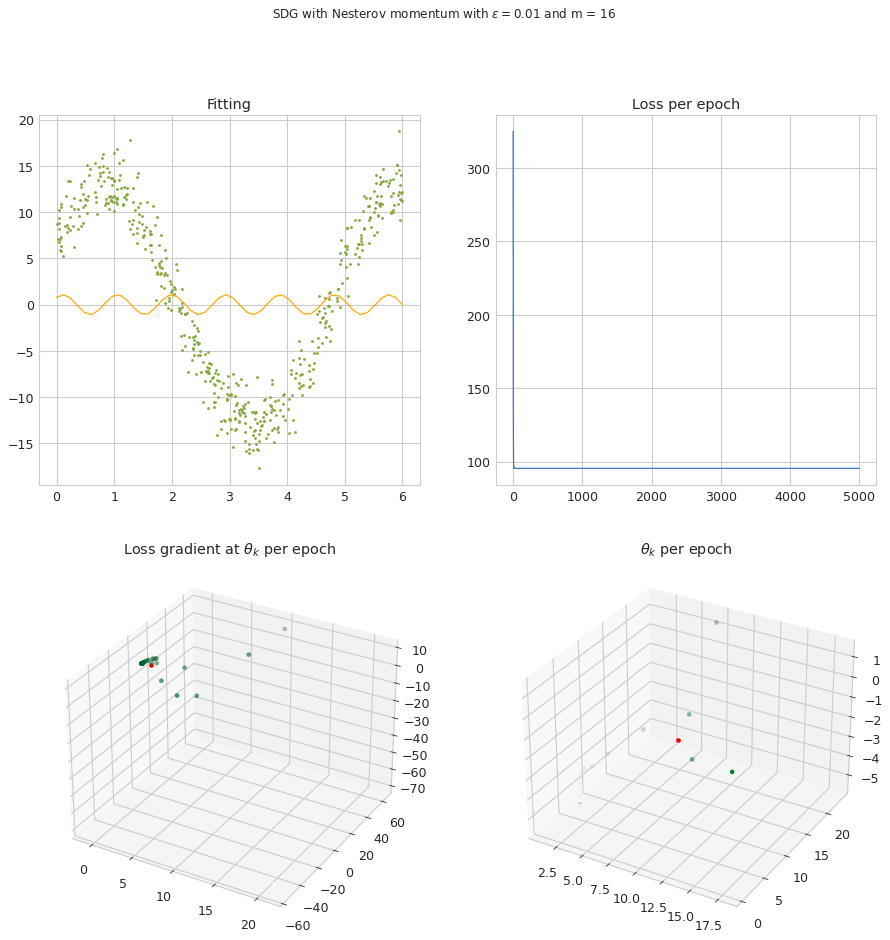

*********************************************** Trial 2 ***********************************************
Loss value at initial point: 324.9823569075869         
Final point: [12.96986838  1.19544125  0.6066569 ]         
Gradient Norm at final point: 3.6380565514584564         
Loss value at final point: 3.863042098550739         
Number of iterations (epochs): 5000         
Time (seconds): 302.060364484787


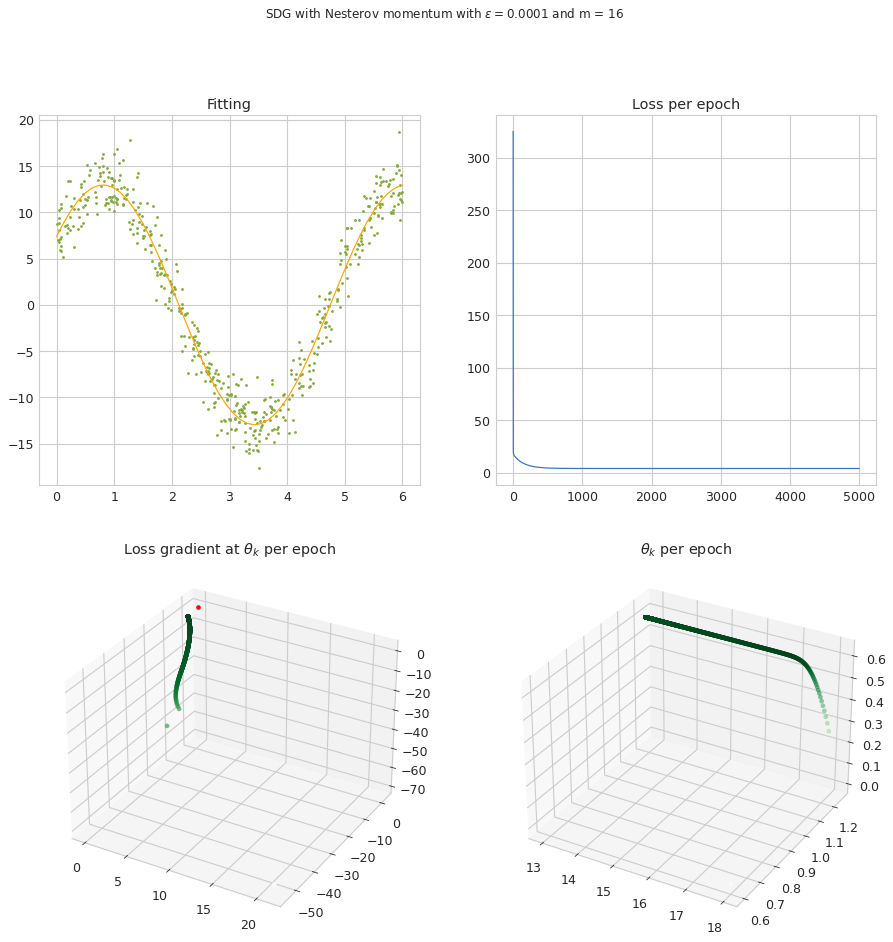

*********************************************** Trial 3 ***********************************************
Loss value at initial point: 324.9823569075869         
Final point: [ 1.15902524 15.0350471   0.47886836]         
Gradient Norm at final point: 0.3362205420765642         
Loss value at final point: 96.1878805799362         
Number of iterations (epochs): 5000         
Time (seconds): 43.76914739608765


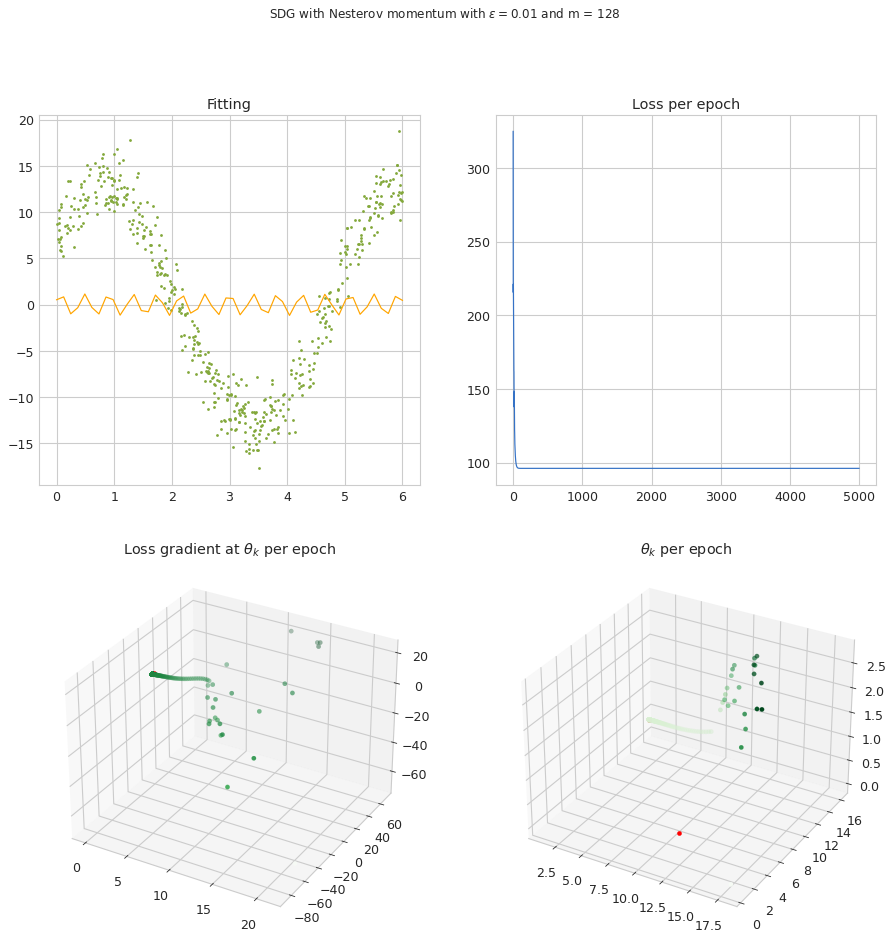

*********************************************** Trial 4 ***********************************************
Loss value at initial point: 324.9823569075869         
Final point: [13.5475769   1.19466698  0.60889556]         
Gradient Norm at final point: 0.626429067491292         
Loss value at final point: 4.039851157168606         
Number of iterations (epochs): 5000         
Time (seconds): 40.65877819061279


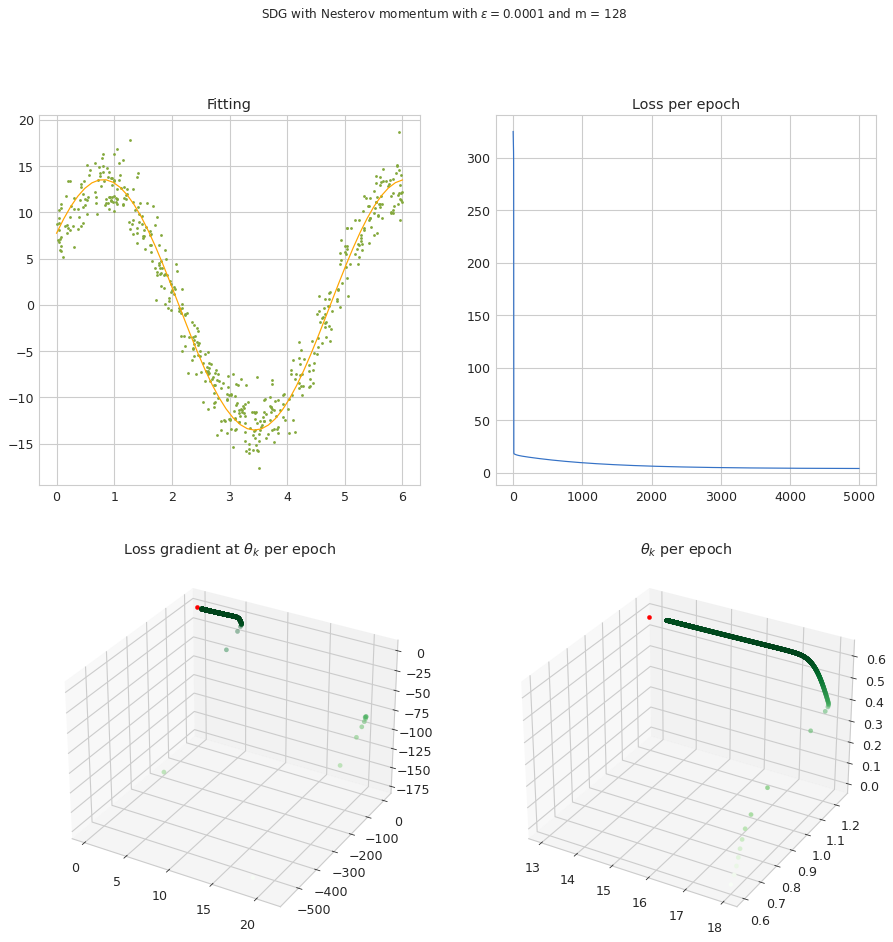

In [158]:
real_parameter = (13, 1.2, 0.6)


batch_sizes = [16,128]
learning_rates = [0.01, 0.0001]
trial = 1
for bs in batch_sizes:
    for lr in learning_rates:
        print(f'*********************************************** Trial {trial} ***********************************************')
        start_time = time.time()
        final_parameter,n_iter, parameter_history = SDG_nesterov(X=X, y=y, batch_size=bs, learning_rate=lr)
        exe_time = (time.time() - start_time)

        print(f'Loss value at initial point: {loss(X, y, fnc_f, theta0)} \
        \nFinal point: {final_parameter} \
        \nGradient Norm at final point: {np.sqrt(np.dot(loss_gradient(X,y,final_parameter),loss_gradient(X,y,final_parameter)))} \
        \nLoss value at final point: {loss(X, y, fnc_f, final_parameter)} \
        \nNumber of iterations (epochs): {n_iter} \
        \nTime (seconds): {exe_time}') 

        loss_values = np.array([loss(X, y, fnc_f, parameter) for parameter in parameter_history])

        figure = plt.figure(figsize=(15,15))

        # For Fitting plot

        vx = np.linspace(0, 6, 50)

        axis1 = figure.add_subplot(2, 2, 1)
        axis1.plot(X, y, 'g.')
        axis1.plot(vx, fnc_f(vx, final_parameter), 'orange')
        axis1.set_title("Fitting")

        # For Loss per epoch
        axis2 = figure.add_subplot(2, 2, 2)
        axis2.plot(loss_values)
        axis2.set_title("Loss per epoch")





        # For Gradient plot

        # Data for three-dimensional scattered points
        xdata = [loss_gradient(X,y,parameter)[0] for parameter in parameter_history]
        ydata = [loss_gradient(X,y,parameter)[1] for parameter in parameter_history]
        zdata = [loss_gradient(X,y,parameter)[2] for parameter in parameter_history]

        axis3 = figure.add_subplot(2, 2, 3, projection='3d')
        axis3.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')
        axis3.scatter3D(loss_gradient(X,y,real_parameter)[0],
                     loss_gradient(X,y,real_parameter)[1],
                     loss_gradient(X,y,real_parameter)[2], color='red')
        axis3.scatter3D(loss_gradient(X,y,final_parameter)[0],
                     loss_gradient(X,y,final_parameter)[1],
                     loss_gradient(X,y,final_parameter)[2], color='red')
        axis3.set_title(r'Loss gradient at $\theta_k$ per epoch')


        # For parameter tracking
        xdata = [parameter[0] for parameter in parameter_history]
        ydata = [parameter[1] for parameter in parameter_history]
        zdata = [parameter[2] for parameter in parameter_history]

        axis4 = figure.add_subplot(2, 2, 4, projection='3d')        
        axis4.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')
        axis4.scatter3D(real_parameter[0],
                     real_parameter[1],
                     real_parameter[2], color='red')
        axis4.scatter3D(final_parameter[0],
                     final_parameter[1],
                     final_parameter[2], color='red')
        axis4.set_title(r'$\theta_k$ per epoch')
        
        # Combine all the operations and display
        figure.suptitle(r'SDG with Nesterov momentum with $\epsilon = $' + str(lr) + ' and m = '+str(bs))
        plt.show()
        
        trial += 1

**Comentario**

Es posible percatarse que la elección del tamaño de paso es importante, pues en el anterior ejemplo, tomando $\epsilon = 0.01$ es muy fácil caer en un mínimo local y no lograr una buena convergencia. Por otro lado, $\epsilon = 0.0001$ parece ser una buena elección de tamaño de paso, pues se llega a minimizar la función de costo, dejando libre elección sobre el número de épocas (que entre 500 y 1000 está bien, pues no hay mucha variación en la función de costo). 

También es notable la diferencia de tiempo cuando se toma un minibatch pequeño, pues esto implica más iteraciones al final. Por eso, una elección intermedia de tamaño de batch, permitirá converger en menor tiempo.

## Ejercicio 2 

Programar y probar el algoritmo RMSProp.

1. Escriba una función que implemente el algoritmo RMSProp.
2. Repetir las pruebas del Ejercicio 1 y reportar los resultados de la misma manera usando $\rho=0.9$ (página 44 de las diapositivas).
3. Escriba un comentario sobre el efecto de los parámetros en los resultados del optimizador y un comentario sobre una comparación de los dos algoritmos.

### Solución:

In [159]:
def RMSProp(initial_point = np.array([18,0.6, 0]), loss_gradient = loss_gradient, X = None, y = None, 
                 batch_size = 16, epochs = 5000, tol1 = 0.01, tol2 = 0.0001, rho = 0.9,
                 initial_vel = np.array([0.1,0.1,0.1]), learning_rate = 0.0001, alpha = 0.001):
    
    parameter = initial_point
    velocity = initial_vel
    epoch = 1
    r = np.array([0,0,0])
    
    gradient_norm = np.sqrt(np.dot(loss_gradient(X,y,parameter),loss_gradient(X,y,parameter)))
    velocity_norm = np.sqrt(np.dot(velocity,velocity))
    parameter_history = [parameter]
    minibatches = get_minibatches(X,y,batch_size)
    while epoch < epochs and gradient_norm > tol1 and velocity_norm > tol2:
        for mb in minibatches:
            theta_hat = parameter + alpha*velocity #interim update
            g = loss_gradient(mb[0], mb[1], theta_hat) #gradient at interim point
            r = rho*r + (1-rho)*(g*g)
            velocity = alpha*velocity-learning_rate*(1/np.sqrt(r))*g #velocity update
            parameter = parameter + velocity    
            
            
            gradient_norm = np.sqrt(np.dot(loss_gradient(X,y,parameter),loss_gradient(X,y,parameter)))
            velocity_norm = np.sqrt(np.dot(velocity,velocity))
            
        epoch += 1
        parameter_history.append(parameter)
    
    return (parameter, epoch, parameter_history)


*********************************************** Trial 1 ***********************************************
Loss value at initial point: 324.9823569075869         
Final point: [12.91895001  1.20752346  0.61999158]         
Gradient Norm at final point: 24.67883120072622         
Loss value at final point: 4.024948765226468         
Number of iterations (epochs): 5000         
Time (seconds): 308.89764499664307


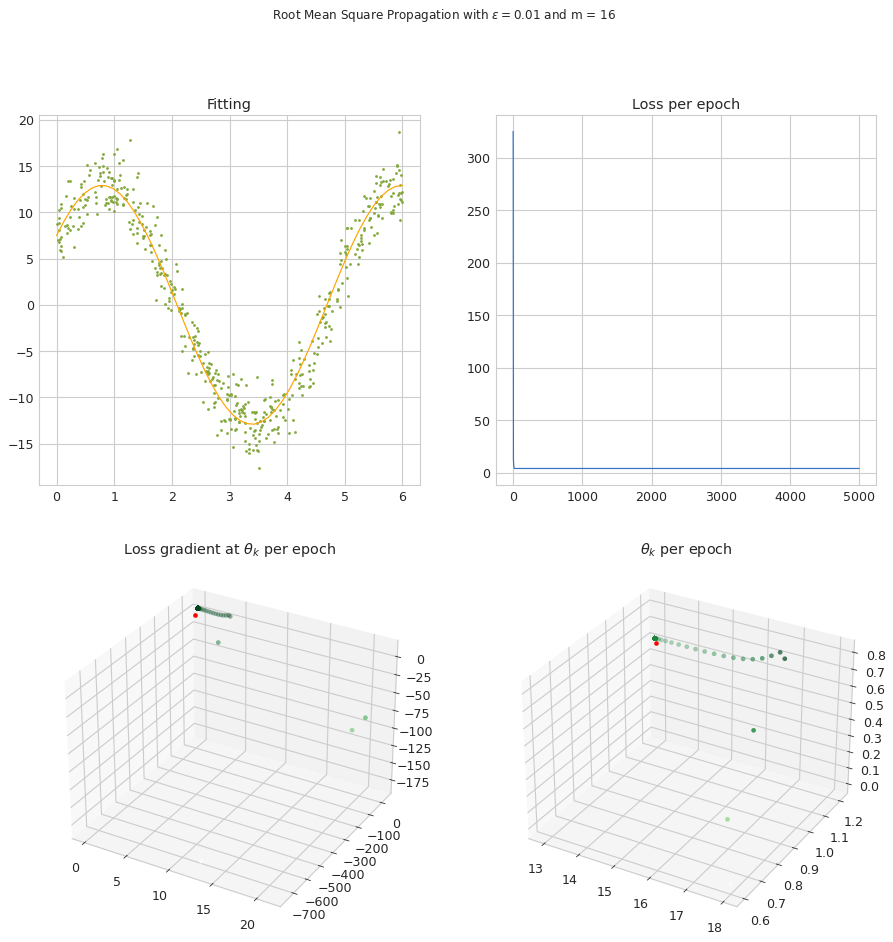

*********************************************** Trial 2 ***********************************************
Loss value at initial point: 324.9823569075869         
Final point: [17.87314336  0.62110212  0.0964577 ]         
Gradient Norm at final point: 88.18965887031503         
Loss value at final point: 314.43285458119726         
Number of iterations (epochs): 41         
Time (seconds): 2.2415759563446045


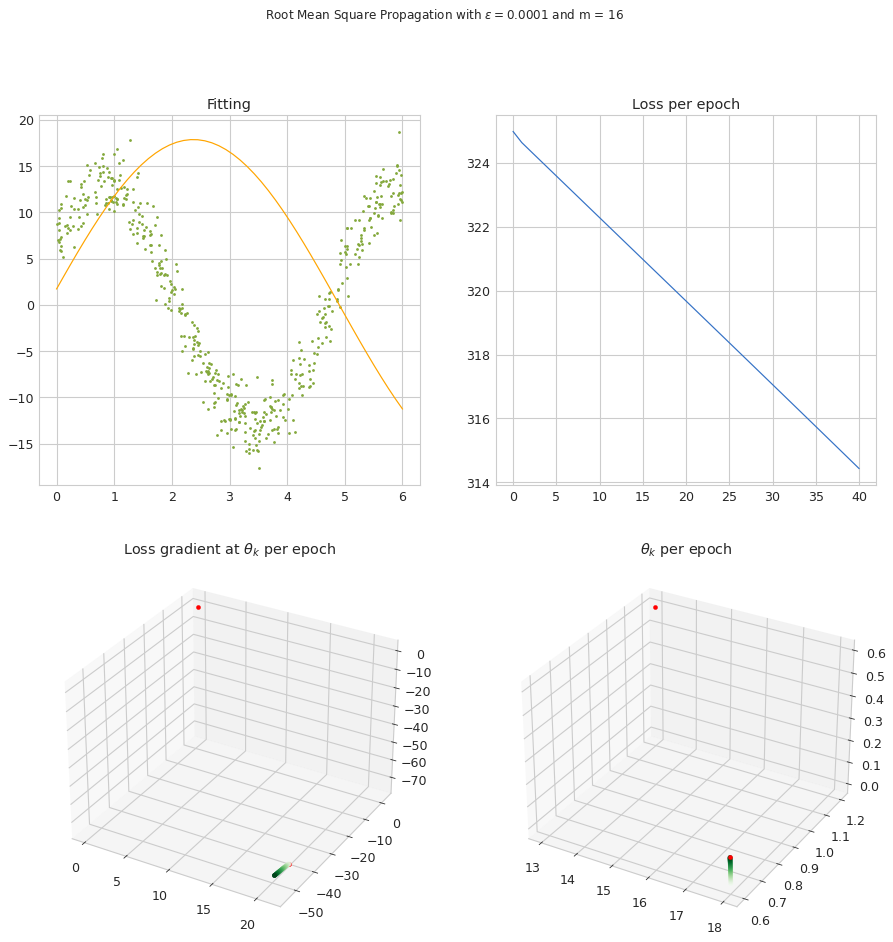

*********************************************** Trial 3 ***********************************************
Loss value at initial point: 324.9823569075869         
Final point: [12.97851348  1.20174197  0.60181904]         
Gradient Norm at final point: 5.9320574323200095         
Loss value at final point: 3.8692175774737563         
Number of iterations (epochs): 5000         
Time (seconds): 38.20293188095093


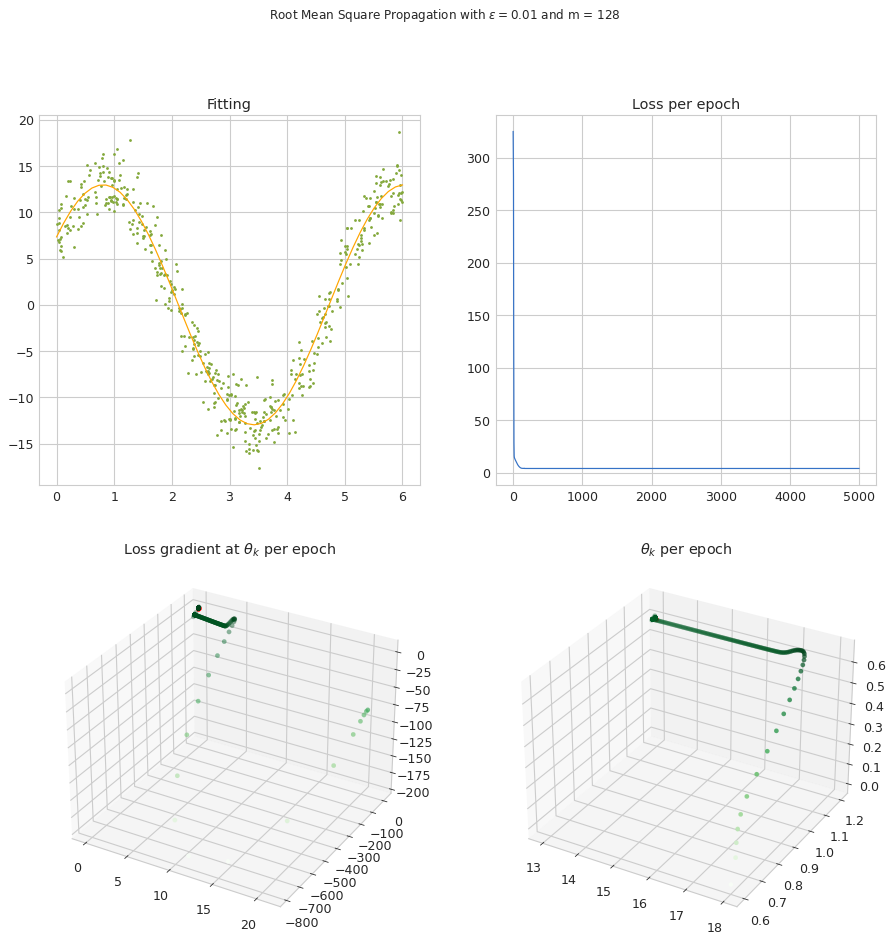

*********************************************** Trial 4 ***********************************************
Loss value at initial point: 324.9823569075869         
Final point: [16.00404035  1.18228958  0.62161514]         
Gradient Norm at final point: 3.2952112216502534         
Loss value at final point: 8.811893811833462         
Number of iterations (epochs): 5000         
Time (seconds): 37.932987213134766


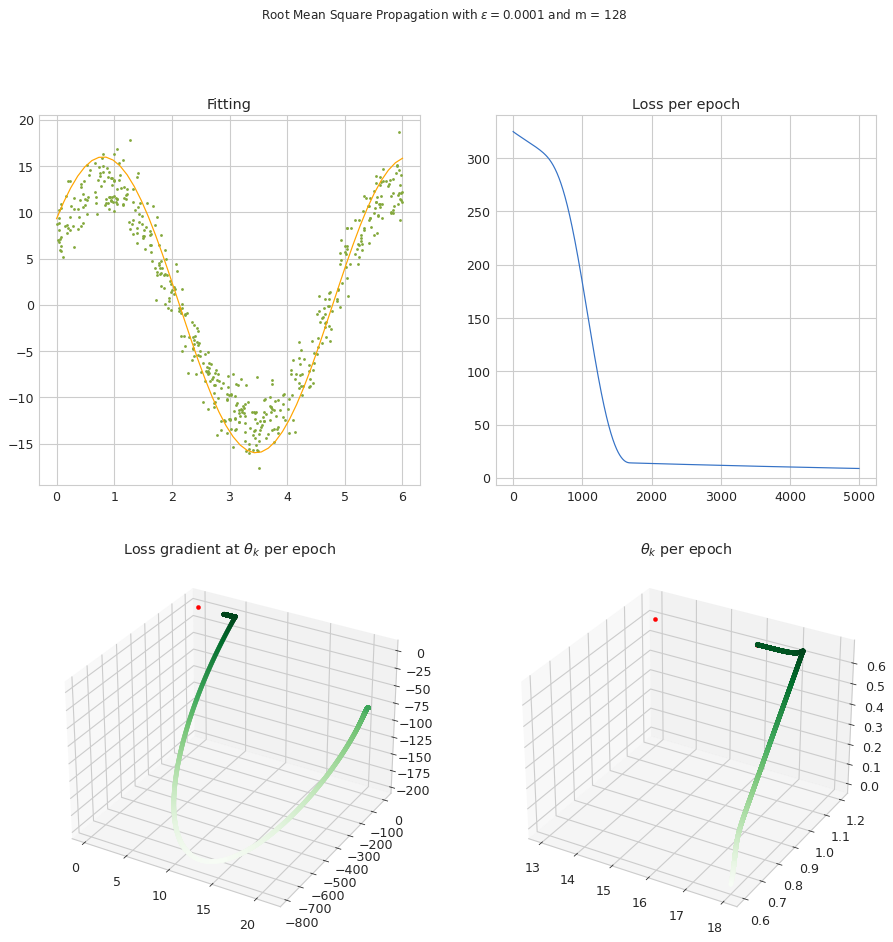

In [160]:
real_parameter = (13, 1.2, 0.6)


batch_sizes = [16,128]
learning_rates = [0.01, 0.0001]
trial = 1
for bs in batch_sizes:
    for lr in learning_rates:
        print(f'*********************************************** Trial {trial} ***********************************************')
        start_time = time.time()
        final_parameter,n_iter, parameter_history = RMSProp(X=X, y=y, batch_size=bs, learning_rate=lr)
        exe_time = (time.time() - start_time)

        print(f'Loss value at initial point: {loss(X, y, fnc_f, theta0)} \
        \nFinal point: {final_parameter} \
        \nGradient Norm at final point: {np.sqrt(np.dot(loss_gradient(X,y,final_parameter),loss_gradient(X,y,final_parameter)))} \
        \nLoss value at final point: {loss(X, y, fnc_f, final_parameter)} \
        \nNumber of iterations (epochs): {n_iter} \
        \nTime (seconds): {exe_time}') 

        loss_values = np.array([loss(X, y, fnc_f, parameter) for parameter in parameter_history])

        figure = plt.figure(figsize=(15,15))

        # For Fitting plot

        vx = np.linspace(0, 6, 50)

        axis1 = figure.add_subplot(2, 2, 1)
        axis1.plot(X, y, 'g.')
        axis1.plot(vx, fnc_f(vx, final_parameter), 'orange')
        axis1.set_title("Fitting")

        # For Loss per epoch
        axis2 = figure.add_subplot(2, 2, 2)
        axis2.plot(loss_values)
        axis2.set_title("Loss per epoch")





        # For Gradient plot

        # Data for three-dimensional scattered points
        xdata = [loss_gradient(X,y,parameter)[0] for parameter in parameter_history]
        ydata = [loss_gradient(X,y,parameter)[1] for parameter in parameter_history]
        zdata = [loss_gradient(X,y,parameter)[2] for parameter in parameter_history]

        axis3 = figure.add_subplot(2, 2, 3, projection='3d')
        axis3.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')
        axis3.scatter3D(loss_gradient(X,y,real_parameter)[0],
                     loss_gradient(X,y,real_parameter)[1],
                     loss_gradient(X,y,real_parameter)[2], color='red')
        axis3.scatter3D(loss_gradient(X,y,final_parameter)[0],
                     loss_gradient(X,y,final_parameter)[1],
                     loss_gradient(X,y,final_parameter)[2], color='red')
        axis3.set_title(r'Loss gradient at $\theta_k$ per epoch')


        # For parameter tracking
        xdata = [parameter[0] for parameter in parameter_history]
        ydata = [parameter[1] for parameter in parameter_history]
        zdata = [parameter[2] for parameter in parameter_history]

        axis4 = figure.add_subplot(2, 2, 4, projection='3d')        
        axis4.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')
        axis4.scatter3D(real_parameter[0],
                     real_parameter[1],
                     real_parameter[2], color='red')
        axis4.scatter3D(final_parameter[0],
                     final_parameter[1],
                     final_parameter[2], color='red')
        axis4.set_title(r'$\theta_k$ per epoch')
        
        # Combine all the operations and display
        figure.suptitle(r'Root Mean Square Propagation with $\epsilon = $' + str(lr) + ' and m = '+str(bs))
        plt.show()
        
        trial += 1

**Comentario**

En este caso, es posible notar que pasa lo contrario a lo que se muestra en el método de SDG con momento Nesterov, pues la tasa de decaimiento, $\rho$, permite que el learning rate no disminuya de manera radical y por lo tanto, presenta mejoras en regiones no convexas.